# Code Assigment 1

For this assignment you will use a set of implementations for classifying these datasets:

https://archive.ics.uci.edu/ml/datasets/banknote+authentication


https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+

You should:

1) Specify which Machine Learning problem are you solving.

2) Provide a short summary of the features and the labels you are working on.

3) Please answer the following questions: a) Are these datasets linearly separable? b) Are these datasets randomly chosen and c) The sample size is enough to guarantee generalization.

4) Hyperparameter tunning.

5) Show some metrics that show the models are working properly.

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
np.random.seed(42)



# Validation and searching utils
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report




import matplotlib.pyplot as plt
import seaborn as sns

# Bank note model 

1) Specify which Machine Learning problem are you solving.

2) Provide a short summary of the features and the labels you are working on.

3. Please answer the following questions: 
    1. Are these datasets linearly separable? 
    2. Are these datasets randomly chosen.
    3. The sample size is enough to guarantee generalization.

4) Hyperparameter tuning
5) Show a set of metrics that show how well the model is working

## Solution

### 1 Specify which Machine Learning problem are you solving.
The machine learning problem in this case is to detect counterfeit banknotes, the data is obtained from https://archive.ics.uci.edu/ml/datasets/banknote+authentication , in this case we are in front of a classification problem,  where we try to classify each banknote into two possible classes, counterfeits and genuine banknotes, the objective is to maximize the detection of counterfeit banknotes.

In [23]:
# Load the dataset
df_bank_note = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', header=None)

df_bank_note.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']

In [24]:
df_bank_note['class']=df_bank_note['class'].replace(0,-1)

In [25]:
df_bank_note

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,-1
1,4.54590,8.16740,-2.4586,-1.46210,-1
2,3.86600,-2.63830,1.9242,0.10645,-1
3,3.45660,9.52280,-4.0112,-3.59440,-1
4,0.32924,-4.45520,4.5718,-0.98880,-1
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [26]:
df_bank_note=shuffle(df_bank_note)

In based on this data,in effect, variance, skewness, curtosis and entropy we want to determine the class of every banknote.

In [27]:
print("Class Percentage:")
df_bank_note["class"].value_counts(normalize=True)

Class Percentage:


-1    0.555394
 1    0.444606
Name: class, dtype: float64

### 2  Provide a short summary of the features and the labels you are working on.

For create this dataset was required to extract the features from images of genuine and forged banknote-like specimens, to do this they use wavelet transformation tool.we are going to introduce briefly the wavelet transformation tool,this transformations works similar to a Fourier tranformation, with the difference that the functions used are wavelets, that is functions of the form:

$$ \psi = -(x-b)e^{\frac{-(x-b)^{2}/2a²}{\sqrt{2\pi}a^{3}}} $$

Were $a$ determines scale and $b$ determines location,the wavelets have the advantage of extract local information , that is, if we want a better model for local information, wavelet transform work better than Fourier tranform, in this case since the genuine banknotes have local information to proof that is in fact genuine (like watermarks and othes markers) this information is so relevant, that is the reason for use wavelet transformation insted of Fourier or other transform,the wavelet transform in the  from this transformation the features want to describe the wavelets distributions,following this reasoning we obtain.

1. variance of Wavelet Transformed image (continuous):
    Over the distribution of wavelets transformation, we want to know his variance, the variance is a interesting value for our problem because a forged banknote probably have diferent ranges that a genuine.
2. Skewness of Wavelet Transformed image (continuous):
    The skewness give us a measure of the simetry of the distribution, we can think that exists a correlation between a class and his simetry of distribution.
3. Curtosis of Wavelet Transformed image (continuous)
    Curtosis is a measure of the density of the distribution,that give us information about the distribution of the pixels and can describe a principal element of the banknote.
    
4. Entropy of image (continuous)
    If we work with pixels like a random variable, the entropy show us the "disorder" or uncertainty in this random variable, the use of specific materials and inks determine if a banknote are genuine or not, this can be characterised with the entropy, because the behaviour of the pixels with some materials can be defined by his entropy.  
5. class (integer)
    In this case we have two categories, the dataset description do not have the meaning of the class, but we could think that 0 is genuine and 1 is forged.

In [28]:
df_bank_note.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,-0.110787
std,2.842763,5.869047,4.310030,2.101013,0.994207
min,-7.042100,-13.773100,-5.286100,-8.548200,-1.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,-1.000000
50%,0.496180,2.319650,0.616630,-0.586650,-1.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


Here we can observe the different statistics measures of the data as a summary of principal statistical information of every variable.

### 3 Answer questions

* ¿Are this dataset linearly separable?

To see that this dataset is linearly separable we have to find a separator hiperplane that induce two partitions, in both cases we only need to find the support vector machine, if we can find it, then the data are linearly separable. But we could also run a logistic regression algorithm to see that we could separate the set of points in two collections, we are going to run a logistic regression algorithm to see that the data are separable and after a SVM algorithm.Also we are going to visualize the dataset and see if the two datasets looks like if were separables,in fact:

Text(0.5, 0.98, 'Marginal plot and distributions')

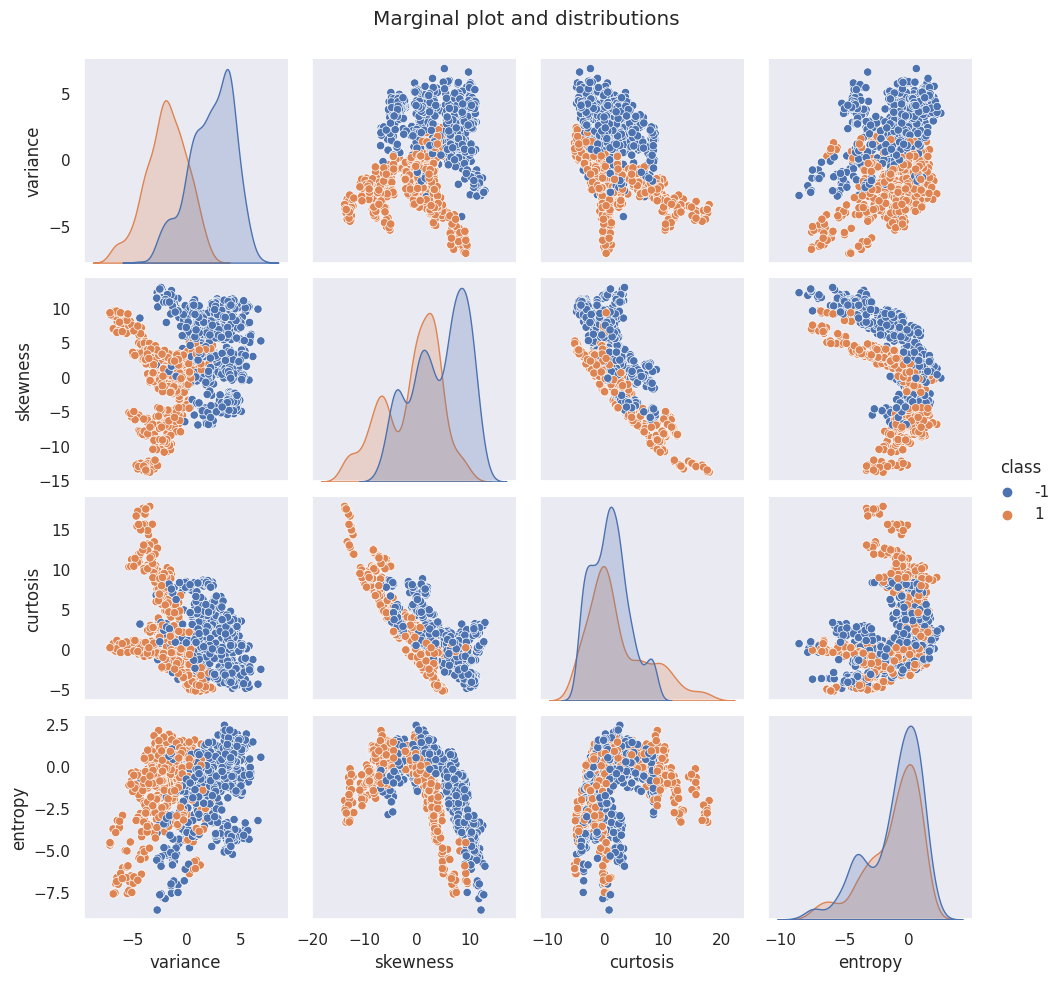

In [29]:
# Visualizing data

pair=sns.pairplot(df_bank_note, hue="class",palette='deep')
pair.fig.subplots_adjust(top=.93)
pair.fig.suptitle('Marginal plot and distributions')

We can see that the distributions of de data in both cases looks different and distinguible one for another.And also we can see a correlation matrix to see that the data are related to the labels.

<AxesSubplot: title={'center': 'Correlation Matrix'}>

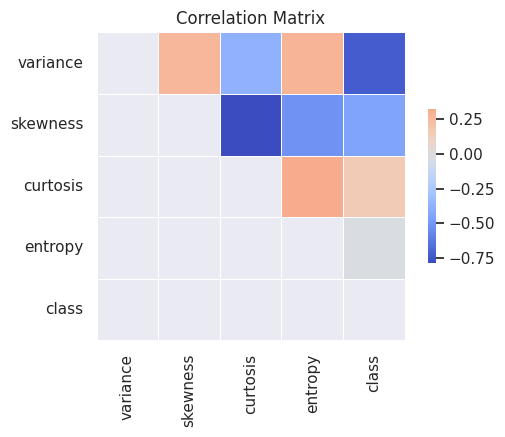

In [30]:
sns.set_theme(style="dark")
corr = df_bank_note.corr()
mask = np.triu(np.ones_like(corr, dtype=bool)).T
f, ax = plt.subplots(figsize=(6,4))
ax.set_title("Correlation Matrix")
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, center=0,cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [31]:
X =df_bank_note.drop('class',axis=1).values
y= df_bank_note['class'].values

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [32]:
X.shape

(1372, 4)

* The sample size is $1372$ and the dimension of every observation are $4$ , the dimesion $VC$ of a support vector machine is $d+1$ , in this case is $5$ then we can use an heuristics that if $N$ fulfil that $10d_{vc}(\mathcal{H})\leq N$ then the model can generalize. In this case $50\leq N$ and for this reason we can give some guarantee of generalization.  An analogous reasoning give us that all the other the methods can generalize.  

### Hyperparameter tunning



To do this we are going to use the next procedure with every model , in fact

1. Create a list of posible hyperparameters
2. Instantiate a model
3. Use GridSearch to find the best hyperparameters
4. Instantiate a new model with the best hyperparameters
5. Calculate the cross validation score and print his value

#### SVM

To know more about the implementation of the support vector machine, the algorithm of optimization and more, you can check the file *models.py* where are the information and the commented code, in summary we create an object with name *SVM* , now we are going to implement the model.

In [33]:

hyperparameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}


model = SVC()

# Create the GridSearchCV object with the model and hyperparameters
grid_search = GridSearchCV(model, hyperparameters, cv=5)

# Fit the model using GridSearchCV and perform cross-validation
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf']})

In [34]:
# Get the best found hyperparameters
best_params = grid_search.best_params_

#  Create a new model with the best hyperparameters
svm = SVC(**best_params)

# Compute the cross-validation scores using the best model
cross_val_scores = cross_val_score(svm, X, y, cv=5)

# Print the average cross-validation score
print("Average cross-validation score:", cross_val_scores.mean())

#  Train the model using all data and the best hyperparameters
svm.fit(X, y)

Average cross-validation score: 1.0


SVC(C=1, gamma=10)

This method optimize the algorithm to the data using a form of gradient descent algorithm to optimize the weights and bias of the support vector machine, we determine the data, the epochs and the learning rate, after this the method print the precision and return the weights and bias of the support vector machine.

#### Logistic Regression

In [35]:
hyperparameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000,10000] ,
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}


model = LogisticRegression()

# Create the GridSearchCV object with the model and hyperparameters
grid_search = GridSearchCV(model, hyperparameters, cv=5)

# Fit the model using GridSearchCV and perform cross-validation
grid_search.fit(X, y)


/home/silverwolf/anaconda3/envs/Datascience/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/silverwolf/anaconda3/envs/Datascience/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/silverwolf/anaconda3/envs/Datascience/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/silverwolf/anaconda3/envs/Datascience/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/silverwolf/anaconda3/envs/Datascience/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [36]:
# Get the best found hyperparameters
best_params = grid_search.best_params_

#  Create a new model with the best hyperparameters
Lg = LogisticRegression(**best_params)

#  Compute the cross-validation scores using the best model
cross_val_scores = cross_val_score(Lg, X, y, cv=5)

#  Print the average cross-validation score
print("Average cross-validation score:", cross_val_scores.mean())

#  Train the model using all data and the best hyperparameters
Lg.fit(X, y)


Average cross-validation score: 0.9897942932979429


LogisticRegression(C=10, penalty='l1', solver='liblinear')

#### Decision Three

In [37]:

hyperparameters = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


model = DecisionTreeClassifier()


grid_search = GridSearchCV(model, hyperparameters, cv=5)


grid_search.fit(X, y)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [38]:

best_params = grid_search.best_params_


D3 = DecisionTreeClassifier(**best_params)


cross_val_scores = cross_val_score(D3, X, y, cv=5)


print("Average cross-validation score:", cross_val_scores.mean())


D3.fit(X, y)

Average cross-validation score: 0.9839601857996019


DecisionTreeClassifier(max_depth=10, min_samples_split=10)

#### K-Nearest Neighbor (KNN)

In [39]:

hyperparameters = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = KNeighborsClassifier()


grid_search = GridSearchCV(model, hyperparameters, cv=5)


grid_search.fit(X, y)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [40]:
best_params = grid_search.best_params_


Knn = KNeighborsClassifier(**best_params)



print("Average cross-validation score:", cross_val_scores.mean())


Knn.fit(X, y)


Average cross-validation score: 0.9985401459854014


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

### Evaluation models 

In [41]:
def evaluate_model(model, X, y):

    y_pred = model.predict(X)
    
    metrics = {
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred),
        'Recall': recall_score(y, y_pred),
        'F1-Score': f1_score(y, y_pred)
    }
    
    return metrics

In [46]:
models = [svm,Knn,Lg, D3]
model_type=['Support Vector Machine','K-Nearest Neighbors','Logistic Regression','Decision three']
count=0
for model in models:
    
    print(model_type[count])
    evaluation=evaluate_model(model,X,y)
    for key in evaluation:
        print (f'{key}:{evaluation[key]}')
    count+=1
    print('\n')

Support Vector Machine
Accuracy:1.0
Precision:1.0
Recall:1.0
F1-Score:1.0


K-Nearest Neighbors
Accuracy:0.9985422740524781
Precision:0.9967320261437909
Recall:1.0
F1-Score:0.9983633387888707


Logistic Regression
Accuracy:0.9897959183673469
Precision:0.9837662337662337
Recall:0.9934426229508196
F1-Score:0.9885807504078303


Decision three
Accuracy:0.9978134110787172
Precision:0.9967266775777414
Recall:0.9983606557377049
F1-Score:0.9975429975429976


